In [40]:
import math
import pandas as pd
from numpy import *
import matplotlib.pyplot as plt 

import datetime

import os, time

import numpy as np
import matplotlib.pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision

import pandas as pd
import torch


# Markov crypto strategy 

We suppose daily returns follow a discret markov process.
More precisely, we suppose the retuns boil down to " market goes up" or " market goes down".
We consider the state of a crypto-currency on N days. The daily space is {0,1} and we denote by $X_{t}$ the state of the market at time t;
We suppose X is a Markov chain : the state at time t+1 only depends on precedent time t.We can then estimate transition probabilites.
To make up for a strategy, we estimate the mean future returns associated to each transition probability.
We also introduce a threshold so that we can lift estimation errors due to the considered period ( take Epps effect for example) and to enable us to account for trading fees.

To evalutate our strategy we compare our portfolio value at time t to the " buy and hold " strategy.



In [41]:
def print_pourc(c):
    c = c*10000
    c = int(c)
    print(c/100, end='%\t')
    

# Importing data needed

In [42]:
btcusd_daily = pd.read_csv("datas/Gemini_BTCUSD_d.csv")
ethusd_daily = pd.read_csv("datas/Gemini_ETHUSD_d.csv")
ltcusd_daily = pd.read_csv("datas/Gemini_LTCUSD_d.csv")
zecusd_daily = pd.read_csv("datas/gemini_ZECUSD_day.csv")

btcusd_daily = btcusd_daily.iloc[426:0:-1].set_index([pd.Index([i for i in range(426)])])
ethusd_daily = ethusd_daily.iloc[426:0:-1].set_index([pd.Index([i for i in range(426)])])
ltcusd_daily = ltcusd_daily.iloc[426:0:-1].set_index([pd.Index([i for i in range(426)])])
zecusd_daily = zecusd_daily.iloc[425::-1].set_index([pd.Index([i for i in range(426)])])

# Adding daily returns

In [43]:
btcusd_daily["move"] = (btcusd_daily["Close"] / btcusd_daily["Open"] - 1)* 100
ethusd_daily["move"] = (ethusd_daily["Close"] / ethusd_daily["Open"] - 1)* 100
ltcusd_daily["move"] = (ltcusd_daily["Close"] / ltcusd_daily["Open"] - 1)* 100
zecusd_daily["move"] = (zecusd_daily["Close"] / zecusd_daily["Open"] - 1)* 100

In [44]:
btcusd_daily["move_sgn"] = (np.sign(btcusd_daily["move"]) +1)//2
btcusd_daily["move_sgn"] = btcusd_daily["move_sgn"].astype(int)

ethusd_daily["move_sgn"] = (np.sign(ethusd_daily["move"]) +1)//2
ethusd_daily["move_sgn"] = ethusd_daily["move_sgn"].astype(int)

ltcusd_daily["move_sgn"] = (np.sign(ltcusd_daily["move"]) +1)//2
ltcusd_daily["move_sgn"] = ltcusd_daily["move_sgn"].astype(int)

zecusd_daily["move_sgn"] = (np.sign(zecusd_daily["move"]) +1)//2
zecusd_daily["move_sgn"] = zecusd_daily["move_sgn"].astype(int)

# Training and test database

#  Building our tree = markov chain

In [45]:
class Leaf:
    def __init__(self):
        self.up = 0
        self.up_list = []
        self.down = 0
        self.down_list = []
        self.total = 0
        self.recom = 0
    
    def ratio(self):
        return self.up / self.total
    
    def push(self, x):
        if(x>0):
            self.up = self.up + 1
            self.up_list.append(x)
        else:
            self.down = self.down + 1
            self.down_list.append(x)
        self.total = self.total + 1
    
    def mean_up(self):
        return mean(self.up_list)
    
    def mean_down(self):
        return mean(self.down_list)
    
    def esp_buy(self):
        r = self.ratio()
        return self.mean_up() * r + self.mean_down() * (1-r)
    
    def make_recom(self, threshold, n_min, double_check, threshold_ratio):
        esp = self.esp_buy()
        r = self.ratio()
        self.recom = 0
        if(esp > threshold):
            self.recom = 1
            if(double_check and r < threshold_ratio):
                self.recom = 0
        if(esp < - threshold):
            self.recom = -1
            if(double_check and r > 1 - threshold_ratio):
                self.recom = 0
        if(self.total < n_min):
            self.recom = 0
        

        
def create_tree(deepness):
    if(deepness == 0):
        return Leaf()
    else:
        return [create_tree(deepness - 1), create_tree(deepness - 1)]

def print_tree(tree,deepness, pre=""):
    if(deepness == 0):
        print("Ordre: ", pre)
        print("Number of : ", tree.total)
        print("Ups: ", tree.up, "(", tree.ratio(), "%, win ",tree.mean_up(),")")
        print("Downs: ", tree.down, "(", 1 - tree.ratio(), "%, loss ",tree.mean_down(),")")
        print("Buying expectancy: ", tree.esp_buy())
        print()
        
    else:
        print_tree(tree[0], deepness-1, pre + '0')
        print_tree(tree[1], deepness-1, pre + '1')

def print_pretty_tree(tree,deepness, pre="", first=True, recom=False):
    if(first):
        add_txt = ''
        if recom:
            add_txt = "\t recom"
        print("State\t n\t up\t down\t esp_up\t esp_down\t esp"+add_txt)
    if(deepness == 0):
        print(pre,end='\t')
        print(tree.total,end='\t')
        print_pourc(tree.ratio())
        print_pourc(1-tree.ratio())
        print_pourc(tree.mean_up()/100)
        print_pourc(tree.mean_down()/100)
        print_pourc(tree.esp_buy()/100)
        if(recom):
            print(tree.recom, end='\t')
        print()
        
    else:
        print_pretty_tree(tree[0], deepness-1, pre + '0', first=False, recom=recom)
        print_pretty_tree(tree[1], deepness-1, pre + '1', first=False, recom=recom)

def print_recom_tree(tree,deepness, pre=""):
    if(deepness == 0):
        print("order: ", pre)
        print("Reco: ", tree.recom)
        print()
        
    else:
        print_recom_tree(tree[0], deepness-1, pre + '0')
        print_recom_tree(tree[1], deepness-1, pre + '1')

def make_recom(tree,deepness, threshold=0.0, n_min = 0, double_check = False, threshold_ratio=0.5):
    if(deepness == 0):
        tree.make_recom(threshold, n_min, double_check, threshold_ratio)
    else:
        make_recom(tree[0],deepness - 1,threshold, n_min, double_check, threshold_ratio)
        make_recom(tree[1],deepness - 1,threshold, n_min, double_check, threshold_ratio)

def make_datas(deepness, length_train, tmp_datas):
    train_db = tmp_datas.iloc[:length_train]
    test_db = tmp_datas.iloc[length_train-deepness:] # ON NE PREDIT PAS LES deepness PREMIERS
    test_db = test_db.set_index([pd.Index([i for i in range(len(test_db))])])
    return train_db, test_db

In [46]:
def train_tree(deepness, length_train, train_db):
    tree = create_tree(deepness)
    for i in range(length_train - deepness):
        loc_tree = tree
        for j in range(deepness):
            loc_tree = loc_tree[train_db["move_sgn"][i+j]]
        loc_tree.push(train_db["move"][i+deepness])
    return tree

In [47]:
def test_tree_noshort(deepness, tree, test, fees = 0.002):
    portfolio = [100.0]
    portfoliofees = [100.0]
    buyandhold = [100.0]
    
    hold = 0
    new_hold = 0
    remaining = 1 - fees
    
    for i in range(deepness, len(test)):
        loc_tree = tree
        for j in range(deepness):
            loc_tree = loc_tree[test["move_sgn"][i-deepness+j]]
    
        if(loc_tree.recom == 1):
            portfolio.append(portfolio[-1]*(1+test["move"][i]/100))
            portfoliofees.append(portfoliofees[-1]*(1+test["move"][i]/100))
            new_hold = 1
        else:
            portfolio.append(portfolio[-1])
            portfoliofees.append(portfoliofees[-1])
            new_hold = 0
        if hold != new_hold:
            portfoliofees[-1] = portfoliofees[-1] * remaining 
            hold = new_hold

        buyandhold.append(buyandhold[-1]*(1+test["move"][i]/100))
        
    return portfolio, portfoliofees, buyandhold

In [48]:
def test_tree_short(deepness, tree, test, fees = 0.002, leverage=1):
    portfolio = [100.0]
    portfoliofees = [100.0]
    buyandhold = [100.0]
    
    hold = 0
    new_hold = 0
    remaining = 1 - fees
    
    for i in range(deepness, len(test)):
        loc_tree = tree
        for j in range(deepness):
            loc_tree = loc_tree[test["move_sgn"][i-deepness+j]]
    
        if(loc_tree.recom == 1):
            portfolio.append(portfolio[-1]*(1+test["move"][i]/100))
            portfoliofees.append(portfoliofees[-1]*(1+test["move"][i]/100))
            new_hold = 1
        else:
            if(loc_tree.recom == -1):
                portfolio.append(portfolio[-1]*(1-leverage*test["move"][i]/100))
                portfoliofees.append(portfoliofees[-1]*(1-leverage*test["move"][i]/100))
                new_hold = -1
            else:
                portfolio.append(portfolio[-1])
                portfoliofees.append(portfoliofees[-1])
                new_hold = 0
        if hold != new_hold:
            portfoliofees[-1] = portfoliofees[-1] * remaining 
            hold = new_hold
        buyandhold.append(buyandhold[-1]*(1+test["move"][i]/100))
            
    return portfolio, portfoliofees, buyandhold

# Prediction

In [49]:
deepness = 4
length_train = 300
datas = btcusd_daily
fees = 0.001

train_db, test_db= make_datas(deepness, length_train, datas)

threshold = fees + abs(np.mean(train_db.move))

name = "BTC_4_pred"

In [50]:
tree = train_tree(deepness, length_train, train_db)
make_recom(tree, deepness, threshold=threshold)
print_pretty_tree(tree, deepness, recom=True)


State	 n	 up	 down	 esp_up	 esp_down	 esp	 recom
0000	7	85.71%	14.28%	4.28%	-0.99%	3.53%	1	
0001	14	64.28%	35.71%	2.93%	-0.9%	1.55%	1	
0010	19	52.63%	47.36%	1.54%	-3.92%	-1.05%	-1	
0011	18	61.11%	38.88%	2.2%	-2.07%	0.53%	1	
0100	23	52.17%	47.82%	2.17%	-3.2%	-0.4%	-1	
0101	19	42.1%	57.89%	2.45%	-1.25%	0.3%	0	
0110	14	50.0%	50.0%	1.79%	-2.2%	-0.2%	0	
0111	20	60.0%	40.0%	3.52%	-2.25%	1.21%	1	
1000	14	57.14%	42.85%	3.43%	-1.98%	1.11%	1	
1001	23	39.13%	60.86%	1.15%	-2.82%	-1.27%	-1	
1010	23	39.13%	60.86%	1.82%	-2.06%	-0.54%	-1	
1011	17	58.82%	41.17%	2.59%	-2.36%	0.55%	1	
1100	14	78.57%	21.42%	2.09%	-1.95%	1.22%	1	
1101	21	42.85%	57.14%	2.12%	-1.73%	-0.08%	0	
1110	20	65.0%	35.0%	3.11%	-3.4%	0.83%	1	
1111	30	60.0%	40.0%	4.3%	-2.77%	1.47%	1	


In [51]:
portfolio, portfoliofees, buyandhold = test_tree_noshort(deepness, tree, test_db, fees=fees)

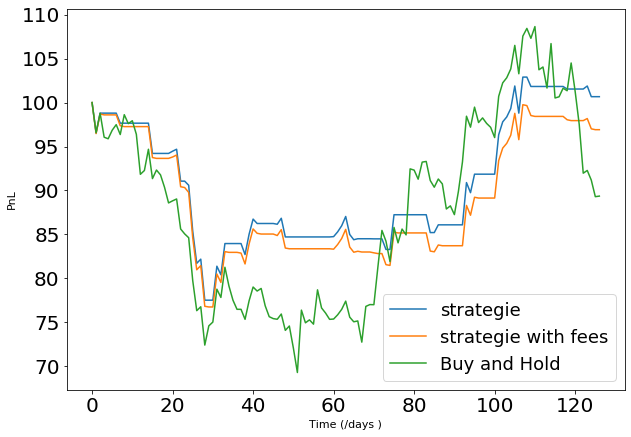

In [52]:
fig = plt.figure(figsize=(10,7))

plt.plot(portfolio, label='strategie')
plt.plot(portfoliofees, label='strategie with fees')
plt.plot(buyandhold, label='Buy and Hold')
plt.legend()

plt.xlabel("Time (/days )", fontsize=11)
plt.ylabel("PnL", fontsize=11)


plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
   
plt.savefig("fig_portfolio_"+name+".png")

plt.show()

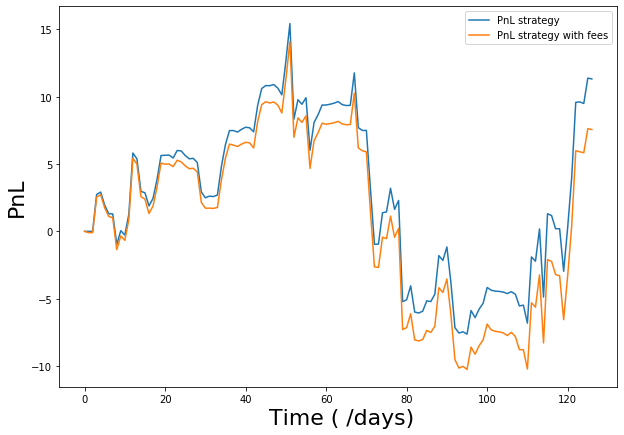

In [53]:
fig = plt.figure(figsize=(10,7))

plt.plot(np.array(portfolio) - np.array(buyandhold), label='PnL strategy')
plt.plot(np.array(portfoliofees) - np.array(buyandhold), label='PnL strategy with fees')
plt.legend()

plt.xlabel(" Time ( /days)", fontsize=22)

plt.ylabel("PnL", fontsize=22)


plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=18)
   
plt.savefig("fig_pnlcomp_"+name+".png")

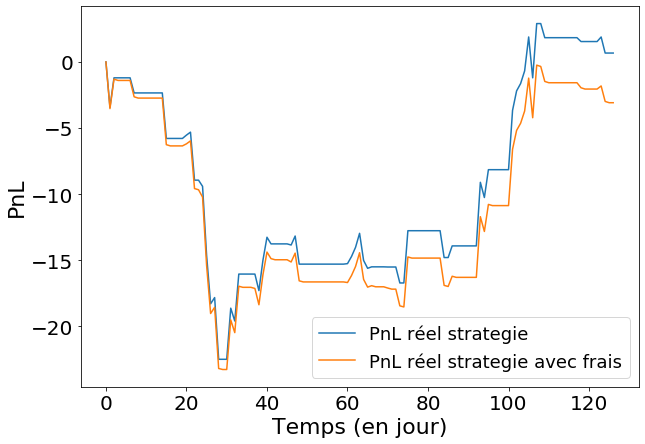

In [54]:
fig = plt.figure(figsize=(10,7))

plt.plot(np.array(portfolio) - 100, label='PnL réel strategie')
plt.plot(np.array(portfoliofees) - 100, label='PnL réel strategie avec frais')
plt.legend()

plt.xlabel("Temps (en jour)", fontsize=22)

plt.ylabel("PnL", fontsize=22)


plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
   
plt.savefig("fig_pnlreel_"+name+".png")

In [55]:
portfolio, portfoliofees, buyandhold = test_tree_short(deepness, tree, test_db, fees=fees)

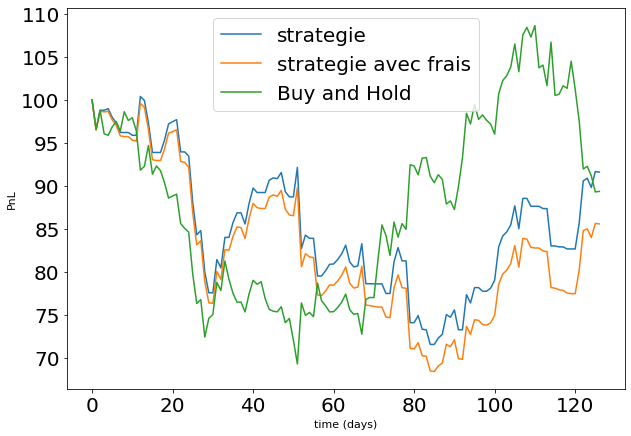

In [56]:
fig = plt.figure(figsize=(10,7))

plt.plot(portfolio, label='strategie')
plt.plot(portfoliofees, label='strategie avec frais')
plt.plot(buyandhold, label='Buy and Hold')
plt.legend()

plt.xlabel("time (days)", fontsize=11)
plt.ylabel("PnL", fontsize=11)


plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
   
plt.savefig("fig_portfolio_short_"+name+".png")

plt.show()

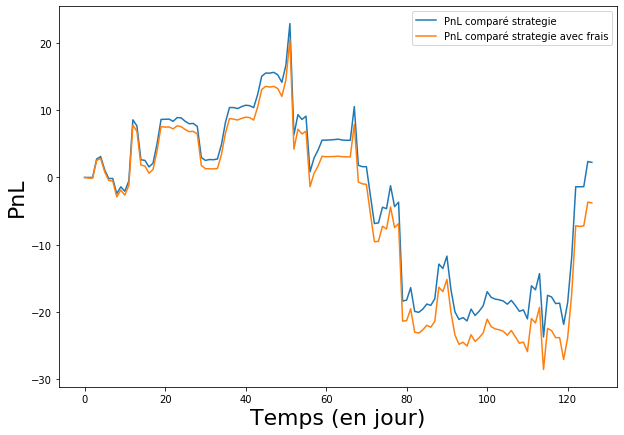

In [57]:
fig = plt.figure(figsize=(10,7))

plt.plot(np.array(portfolio) - np.array(buyandhold), label='PnL comparé strategie')
plt.plot(np.array(portfoliofees) - np.array(buyandhold), label='PnL comparé strategie avec frais')
plt.legend()

plt.xlabel("Temps (en jour)", fontsize=22)

plt.ylabel("PnL", fontsize=22)


plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
   
plt.savefig("fig_pnlcomp_short_"+name+".png")

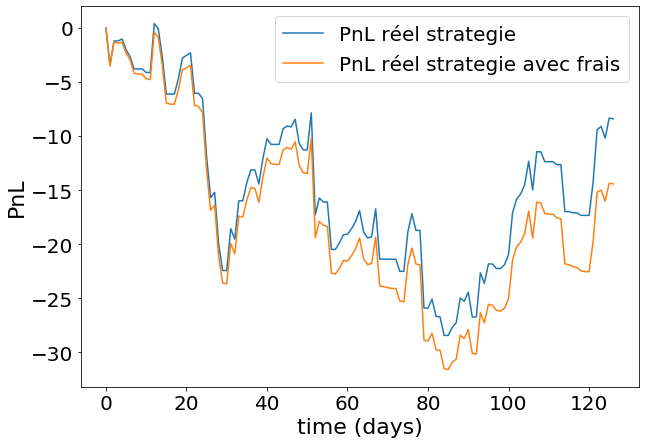

In [58]:
fig = plt.figure(figsize=(10,7))

plt.plot(np.array(portfolio) - 100, label='PnL réel strategie')
plt.plot(np.array(portfoliofees) - 100, label='PnL réel strategie avec frais')
plt.legend()

plt.xlabel("time (days)", fontsize=22)

plt.ylabel("PnL", fontsize=22)


plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
   
plt.savefig("fig_pnlreel_short_"+name+".png")

# Joint prediction

We generalize our approch to a comibnation of cryptocurrencies where we are looking for the one that will be worth the most in the future.

In [59]:
class MultiLeaf:
    def __init__(self):
        self.values = []
        self.recom = 0
        self.total = 0
    
    
    def push(self, x):
        self.values.append(x)
        self.total = self.total + 1
    
    def mean(self):
        v = np.matrix(self.values).mean(0)
        n = v.shape[1]
        return [v[0, i] for i in range(n)]
    
    def make_recom(self, threshold, nb_min):
        esp = self.mean()
        self.recom = -1
        best = 0
        if(self.total < nb_min):
            return
        for i in range(1,len(esp)):
            if esp[i] > esp[best]:
                best = i
        if esp[best] > threshold:
            self.recom = best
        
        

        
def create_multitree(deepness):
    if(deepness == 0):
        return MultiLeaf()
    else:
        return [create_multitree(deepness - 1), create_multitree(deepness - 1)]

def print_multitree(tree,deepness, pre=""):
    if(deepness == 0):
        print("Order: ", pre)
        print("Number of obsevations: ", tree.total)
        print("Buying expectancy: ", tree.mean())
        print()
        
    else:
        print_multitree(tree[0], deepness-1, pre + '0')
        print_multitree(tree[1], deepness-1, pre + '1')

def print_recom_multitree(tree,deepness, pre=""):
    if(deepness == 0):
        print("Order: ", pre)
        print("Reco: ", tree.recom)
        print()
        
    else:
        print_recom_multitree(tree[0], deepness-1, pre + '0')
        print_recom_multitree(tree[1], deepness-1, pre + '1')

def make_recom_multi(tree,deepness, threshold=0.0, nb_min=10):
    if(deepness == 0):
        tree.make_recom(threshold, nb_min)
    else:
        make_recom_multi(tree[0],deepness - 1,threshold,nb_min)
        make_recom_multi(tree[1],deepness - 1,threshold,nb_min)

In [60]:
nb_db = 3 # Number of database
deepness = 1
length_train = 365
normalise = True

list_db = [btcusd_daily, ltcusd_daily, ethusd_daily]
train_db = [x.iloc[:length_train] for x in list_db]
test_db = [x.iloc[length_train-deepness:] for x in list_db]
test_db = [x.set_index([pd.Index([i for i in range(len(x))])]) for x in test_db]

tree = create_multitree(deepness * nb_db)

for i in range(length_train - deepness):
    loc_tree = tree
    for j in range(deepness):
        for k in range(nb_db):
            loc_tree = loc_tree[train_db[k]["move_sgn"][i+j]]
    y = [x["move"][i+deepness] for x in train_db]
    if(normalise):
        m = mean(y)
        y = [z - m for z in y]
    loc_tree.push(y)

print_multitree(tree, deepness* nb_db)

Order:  000
Number of obsevations:  129
Buying expectancy:  [-0.07417832068896357, 0.16882323178214306, -0.0946449110931793]

Order:  001
Number of obsevations:  9
Buying expectancy:  [-0.42447725021008964, 0.04311139479003185, 0.38136585542005813]

Order:  010
Number of obsevations:  16
Buying expectancy:  [-0.12792349318994156, 0.338523751176415, -0.21060025798647353]

Order:  011
Number of obsevations:  18
Buying expectancy:  [-0.38998533822814124, 0.4213311436331704, -0.03134580540502954]

Order:  100
Number of obsevations:  23
Buying expectancy:  [0.24095641506413354, -0.49512452981459815, 0.2541681147504645]

Order:  101
Number of obsevations:  28
Buying expectancy:  [0.8807686715132329, -0.7591227163962894, -0.12164595511694305]

Order:  110
Number of obsevations:  15
Buying expectancy:  [-0.03551176468455545, 0.22022390337998227, -0.18471213869542716]

Order:  111
Number of obsevations:  126
Buying expectancy:  [0.15264877172951374, 0.03522069828879522, -0.18786947001830895]



In [61]:
"""tree[0][0].recom = -1
tree[0][1].recom = -1
tree[1][0].recom = -1
tree[1][1].recom = -1

tree[1][0].recom = 1
tree[0][0].recom = -1"""

if(normalise):
    make_recom_multi(tree, deepness * nb_db, 0,0)
else:
    make_recom_multi(tree, deepness * nb_db, 0.4,20)

print_recom_multitree(tree, deepness * nb_db)



Order:  000
Reco:  1

Order:  001
Reco:  2

Order:  010
Reco:  1

Order:  011
Reco:  1

Order:  100
Reco:  2

Order:  101
Reco:  0

Order:  110
Reco:  1

Order:  111
Reco:  0



In [62]:
portfolio = [100.0]
portfoliofees = [100.0]
buyandhold = [[100.0] for x in list_db]
fees = 0.002
hold = -1

remaining = 1 - fees

for i in range(deepness, len(test_db[0])):
    #print("Iteration", i)
    
    loc_tree = tree
    for j in range(deepness):
        for k in range(nb_db):
            test_db[k]["move_sgn"][i-deepness+j]
            loc_tree = loc_tree[test_db[k]["move_sgn"][i-deepness+j]]
    #        print("On utilise journée", test_db[k]["Date"][i-deepness+j])

    #print("Recommandation finale", loc_tree.recom)
    if(loc_tree.recom == -1):
        portfolio.append(portfolio[-1])
        portfoliofees.append(portfoliofees[-1])
    else:
        coef = (1+test_db[loc_tree.recom]["move"][i]/100) 
        portfolio.append(portfolio[-1]*coef)
        portfoliofees.append(portfoliofees[-1]*coef)
    #    print("Market move", test_db[loc_tree.recom]["move"][i])
    #    print("Market move de la journée", test_db[loc_tree.recom]["Date"][i])
    if(hold != loc_tree.recom and loc_tree.recom != -1):
        #print("Fees", portfoliofees[-1] * fees)
        portfoliofees[-1] = portfoliofees[-1] * remaining

    hold = loc_tree.recom
    
    for k in range(nb_db):
        buyandhold[k].append(buyandhold[k][-1] * (1+test_db[k]["move"][i]/100) )

    #print()

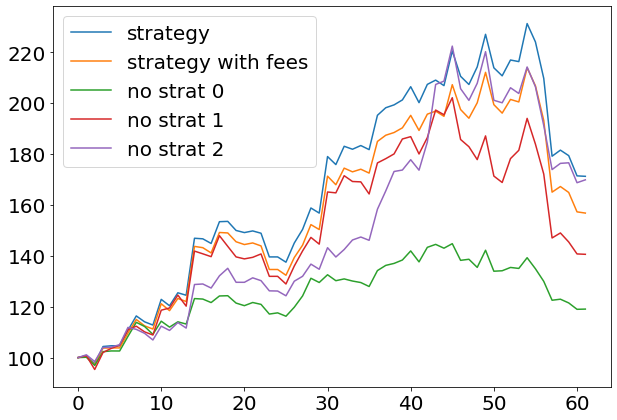

In [64]:
fig = plt.figure(figsize=(10,7))

plt.plot(portfolio, label='strategy')
plt.plot(portfoliofees, label='strategy with fees')
for k in range(nb_db):
    plt.plot(buyandhold[k], label='no strat '+str(k))
plt.legend()